# Data walking project 

*Author: Liubov*; 
*Collaborators: Marc, David

Notebook inspired from http://datawalking.com/

Some previous projects and some visualisations are inspirted from Open humans project https://www.openhumans.org

Read mobility files from Open humans
https://www.openhumans.org/api/public-data/?source=direct-sharing-138

Other notebooks 
https://exploratory.openhumans.org/notebooks/?source=Moves%20connection

Openhumans open API 
https://open-humans-api.readthedocs.io/en/latest/cli.html#example-use-cases


# Content 
1. Data preprocessing
2. Data analysis
3. Data visualisation

# 1. Data preprocessing

We read csv file for trajectories.

In [1]:


#import plotly.plotly as py
#import plotly.graph_objs as go
import pandas as pd
import csv


# load data on trips, it may be heavy 

df = pd.read_csv('datawalking_20160127.csv')

print(df.shape)
print(df.columns)
df.head(5)

(3158, 9)
Index(['latitude', 'longitude', 'time', 'date', 'light', 'sound value',
       'sound average', 'sound peak', 'temperature'],
      dtype='object')


,latitude,longitude,time,date,light,sound value,sound average,sound peak,temperature
0,51.501976,0.005772,14:29:1,27/1/2016,33,1,8.26,46,18.36
1,51.502010,0.005813,14:29:3,27/1/2016,33,18,10.04,91,18.36
2,51.502010,0.005800,14:29:4,27/1/2016,32,1,8.87,129,18.85
3,51.502010,0.005797,14:29:4,27/1/2016,39,9,14.59,87,18.85
4,51.502018,0.005802,14:29:6,27/1/2016,106,18,78.17,390,18.36



## Function to calculate distance between two data points

In [2]:

from math import sin, cos, sqrt, atan2

# function to calculate distance between two data points

R = 6373.0
def dist_lat_lon(lat1,lon1,lat2,lon2):
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance


# 2. Data visualisation 

Here we visualise trajectory on the map.
We also upload the notebook to the OH website https://open-humans-api.readthedocs.io/en/latest/cli.html#upload-files-to-the-accounts-of-your-project-members 

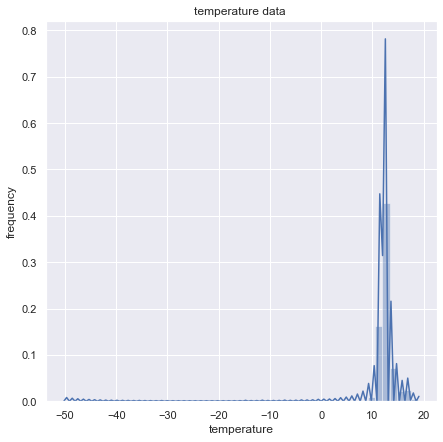

In [4]:
# plot time-difference "delta"-column distribution 


import seaborn as sns, numpy as np
import matplotlib.pyplot as plt

sns.set()

f, ax = plt.subplots(figsize=(7, 7))
#ax.set( yscale="log")
ax = sns.distplot(df.temperature.values)
plt.title('temperature data ')
plt.xlabel('temperature')
plt.ylabel('frequency')
plt.show()


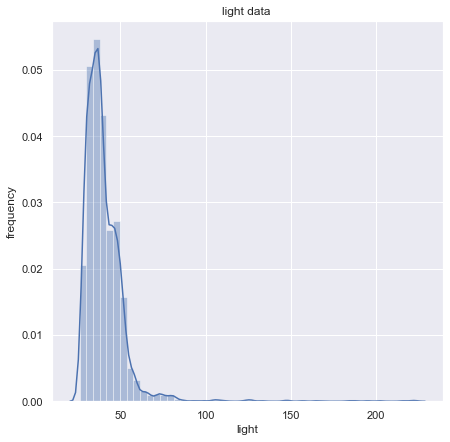

In [5]:
# plot time-difference "delta"-column distribution 


import seaborn as sns, numpy as np
import matplotlib.pyplot as plt

sns.set()

f, ax = plt.subplots(figsize=(7, 7))
#ax.set( yscale="log")
ax = sns.distplot(df.light.values)
plt.title('light data ')
plt.xlabel('light')
plt.ylabel('frequency')
plt.show()


In [10]:
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.cm as cm
import folium

# function to visualise trajectories on a map 

def visualise_df_traj(df):#, lat_values, lon_values):
    ''' function to visusalise trajectories on a map
    input:
    lat_values = df.latitude.values
    lon_values = df.longitude.values'''
    
    latitude = df.latitude.values
    longitude = df.longitude.values

    #then we zip two arrays of lat, lon of datapoints
    latlon1 = list(zip(latitude, longitude))


    #We put map to show first location of Paris 48.8566° North, 2.3522° est
    mapit = folium.Map( location=[48.75 , 2.35], zoom_start=6 )
    for coord in latlon1:
        folium.Marker( location=[ coord[0], coord[1] ], fill_color='#43d9de', radius=8 ).add_to( mapit )
    mapit


    #draw connecting line between locations written in latlon file

#    trips = df.tripid # different trips
#    array_trip = np.unique(trips) 
    SAF=folium.PolyLine(locations=latlon1,weight=5,color = 'r')#color_array[ind])
    mapit.add_child(SAF)
    #do not use plt.show with folium!
    


In [11]:
#run function
lat_values = df.latitude.values
lon_values = df.longitude.values

visualise_df_traj(df)#, lat_values, lon_values)




In [13]:
# use folium map without function 
# attention Folium map may be quite heave when you run it
latitude = df.latitude.values
longitude = df.longitude.values


#then we zip two arrays of lat, lon of datapoints
latlon1 = list(zip(latitude, longitude))


#we put map to show first location of Paris 48.8566° North, 2.3522° est
mapit = folium.Map( location=[48.75 , 2.35], zoom_start=6 )
for coord in latlon1:
    folium.Marker( location=[ coord[0], coord[1] ], fill_color='#43d9de', radius=8 ).add_to( mapit )
mapit


#draw connecting line between locations written in latlon file

SAF=folium.PolyLine(locations=latlon1,weight=5,color = 'r')#color_array[ind])
mapit.add_child(SAF)
#plt.show()







# 3. Data analysis

Here we do trajectories analysis of researchers and user profiling:

0. we analyze distributions of trip durations, trip lengths 
1. we analyze frequencies of cities and places visited
2. we calculate the number of amenities of places around the trajectories in places, where researchers stayed the longest
3. we analyze possible common properties of trajectories of researchers




In [54]:
#functions inserted from OH notebook 

import json
from pprint import pprint



'''
Functions:
 to estimate the distribution of stop duration
 to estimate the distribution of jump length
'''



def len_jumps_distribution(daily_segments):
    """
    takes a daily segment of Moves 
    returns the distribution of jumps lengths (calculated from lat/long of stops)
    can be misleading for days w/ lots of travel etc. 
    """
    places_of_traj = [] #returns array of all locations during the day
    for i in daily_segments: 
        if i['type'] == 'place':
            place_location = i['place']['location']
            places_of_traj.append([place_location])
    return places_of_traj


def longest_daily_location(daily_segments):
    """
    Function from Bastian (Open Humans)
       
    takes a daily segment log of Moves and returns the 
    lat/long for the location where most time was spent. 
    Can be misleading for days w/ lots of travel etc. 
    But the most quick/dirty solution for now.
    """
    places_of_day = []
    for i in daily_segments:
        if i['type'] == 'place':
            place_location = i['place']['location']
            start_time = datetime.strptime(i['startTime'],'%Y%m%dT%H%M%S%z')
            end_time = datetime.strptime(i['endTime'],'%Y%m%dT%H%M%S%z')
            duration = end_time - start_time
            places_of_day.append([place_location,duration])
    places_of_day.sort(key=lambda tup: tup[-1],reverse=True)
    return places_of_day[0][0]




# Data analysis preprocessing

We create additional column in dataframe for calculated distance between sequent data points.

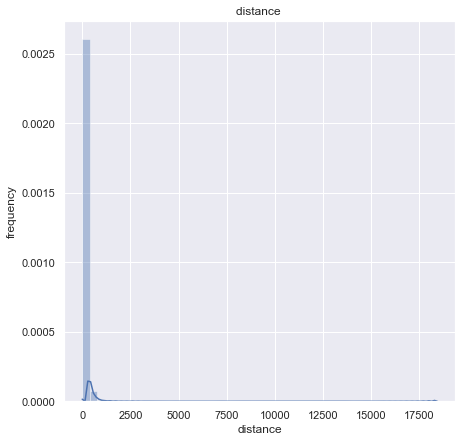

In [75]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt

sns.set()

f, ax = plt.subplots(figsize=(7, 7))
#ax.set( yscale="log")
ax = sns.distplot(df_new.distance.values)
plt.title('distance ')
plt.xlabel('distance')
plt.ylabel('frequency')
plt.show()


# Alternative interactive visualisation

We use kepler.gl for plotting the data. For this one would need kepler.gl installed or you can run generated file on kepler.gl website in the browser.

Alternative visualisations can be done using
1. https://mode.com/blog/python-interactive-plot-libraries
2. https://github.com/keplergl/kepler.gl

In [ ]:
import keplergl

# Load a map with data and config and height
from keplergl import KeplerGl
map_1 = KeplerGl(height=400, data={"data_1": my_df}, config=config)

# DataFrame is loaded

# CSV file loading
with open('df1_ID_'+str(id_research1)+'_researcher.csv', 'r') as f:
    csvData = f.read()
map_1.add_data(data=csvData, name='data_2')

map_1.add_data(data=geojson, name='geojson')